In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Car Mileage Prediction

## Problem Statement
The goal of this project is to build a regression model to predict car fuel efficiency
using vehicle specifications, engine characteristics, and design-related features.

## Why this matters
Fuel efficiency prediction helps manufacturers and buyers make informed decisions
about cost, performance, and environmental impact.


In [131]:
# ===============================
# COMPLETE IMPORTS: EDA → REGRESSION
# ===============================

# Core
import numpy as np
import pandas as pd

# Utilities
import re
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Visualization (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import skew, kurtosis

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Advanced Regressors (optional)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model Persistence
import joblib
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Loading
The dataset is loaded from Google Drive. A copy of the raw data is preserved.

In [132]:
data_path = '/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/data/raw_cars.csv'

data = pd.read_csv(data_path)

df = data.copy()

df.head()

,Dimensions.Height,Dimensions.Length,Dimensions.Width,Engine Information.Driveline,Engine Information.Engine Type,Engine Information.Hybrid,Engine Information.Number of Forward Gears,Engine Information.Transmission,Fuel Information.City mpg,Fuel Information.Fuel Type,Fuel Information.Highway mpg,Identification.Classification,Identification.ID,Identification.Make,Identification.Model Year,Identification.Year,Engine Information.Engine Statistics.Horsepower,Engine Information.Engine Statistics.Torque
0,140,143,202,All-wheel drive,Audi 3.2L 6 cylinder 250hp 236ft-lbs,True,6,6 Speed Automatic Select Shift,18,Gasoline,25,Automatic transmission,2009 Audi A3 3.2,Audi,2009 Audi A3,2009,250,236
1,140,143,202,Front-wheel drive,Audi 2.0L 4 cylinder 200 hp 207 ft-lbs Turbo,True,6,6 Speed Automatic Select Shift,22,Gasoline,28,Automatic transmission,2009 Audi A3 2.0 T AT,Audi,2009 Audi A3,2009,200,207
2,140,143,202,Front-wheel drive,Audi 2.0L 4 cylinder 200 hp 207 ft-lbs Turbo,True,6,6 Speed Manual,21,Gasoline,30,Manual transmission,2009 Audi A3 2.0 T,Audi,2009 Audi A3,2009,200,207
3,140,143,202,All-wheel drive,Audi 2.0L 4 cylinder 200 hp 207 ft-lbs Turbo,True,6,6 Speed Automatic Select Shift,21,Gasoline,28,Automatic transmission,2009 Audi A3 2.0 T Quattro,Audi,2009 Audi A3,2009,200,207
4,140,143,202,All-wheel drive,Audi 2.0L 4 cylinder 200 hp 207 ft-lbs Turbo,True,6,6 Speed Automatic Select Shift,21,Gasoline,28,Automatic transmission,2009 Audi A3 2.0 T Quattro,Audi,2009 Audi A3,2009,200,207


## Initial Data Inspection

This step helps understand:

- Dataset info
- Dataset size
- Data types
- Missing values
- Obvious data issues


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5076 entries, 0 to 5075
Data columns (total 18 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Dimensions.Height                                5076 non-null   int64 
 1   Dimensions.Length                                5076 non-null   int64 
 2   Dimensions.Width                                 5076 non-null   int64 
 3   Engine Information.Driveline                     5076 non-null   object
 4   Engine Information.Engine Type                   5076 non-null   object
 5   Engine Information.Hybrid                        5076 non-null   bool  
 6   Engine Information.Number of Forward Gears       5076 non-null   int64 
 7   Engine Information.Transmission                  5076 non-null   object
 8   Fuel Information.City mpg                        5076 non-null   int64 
 9   Fuel Information.Fuel Type               

In [134]:
print('Rows, Columns',df.shape,'\n'*2,'Size: ',df.size)

Rows, Columns (5076, 18) 

 Size:  91368


## Handling Missing Values
Missing values can negatively affect model training.
Numeric and categorical features are handled appropriately.


In [135]:
df.isnull().sum()

,0
Dimensions.Height,0
Dimensions.Length,0
Dimensions.Width,0
Engine Information.Driveline,0
Engine Information.Engine Type,0
Engine Information.Hybrid,0
Engine Information.Number of Forward Gears,0
Engine Information.Transmission,0
Fuel Information.City mpg,0
Fuel Information.Fuel Type,0


## Handling Duplicate Records
Duplicate rows can bias the model and must be removed.


In [136]:
df.duplicated().sum()

np.int64(18)

In [137]:
df.drop_duplicates(inplace=True)

## Shape & Size

After duplicates removal

In [138]:
print('Rows, Columns',df.shape,'\n'*2,'Size: ',df.size)

Rows, Columns (5058, 18) 

 Size:  91044


In [139]:
df.columns

Index(['Dimensions.Height', 'Dimensions.Length', 'Dimensions.Width',
       'Engine Information.Driveline', 'Engine Information.Engine Type',
       'Engine Information.Hybrid',
       'Engine Information.Number of Forward Gears',
       'Engine Information.Transmission', 'Fuel Information.City mpg',
       'Fuel Information.Fuel Type', 'Fuel Information.Highway mpg',
       'Identification.Classification', 'Identification.ID',
       'Identification.Make', 'Identification.Model Year',
       'Identification.Year',
       'Engine Information.Engine Statistics.Horsepower',
       'Engine Information.Engine Statistics.Torque'],
      dtype='object')

## Anomaly / Misspelt / Wrong Entries / Special Characters Treatment

- Real-world automotive datasets often contain extreme or anomalous values due to measurement errors, data entry issues, or rare vehicle configurations.

- Such anomalies can disproportionately influence regression models and degrade performance.

- Checking each column individually


In [140]:
df['Dimensions.Height'].value_counts()

,count
Dimensions.Height,
190,127
148,115
193,114
195,109
188,105
135,91
82,90
223,86
112,83


In [141]:
df['Dimensions.Length'].value_counts()

,count
Dimensions.Length,
140,139
22,132
215,131
253,111
155,90
184,87
108,86
245,82
233,79


In [142]:
df['Dimensions.Width'].value_counts()

,count
Dimensions.Width,
224,224
212,203
57,202
240,181
237,177
219,141
29,126
214,120
49,113


In [143]:
df['Engine Information.Driveline'].value_counts()

,count
Engine Information.Driveline,
Rear-wheel drive,1741
Front-wheel drive,1568
Four-wheel drive,916
All-wheel drive,833


In [144]:
df['Engine Information.Engine Type'].value_counts()

,count
Engine Information.Engine Type,
Chevrolet 6.2L 8 Cylinder 430 hp 424 ft-lbs,95
Ford 5.4L 8 cylinder 310 hp 365 ft-lbs FFV,78
Nissan 4.0L 6 Cylinder 261 hp 281 ft-lbs,70
Dodge 5.7L 8 Cylinder 390 hp 407 ft-lbs,62
Nissan 5.6L 8 Cylinder 317 hp 385 ft-lbs,58
BMW 3.0L 6 cylinder 300 hp 300 ft-lbs Turbo,56
BMW 3.0L 6 cylinder 230hp 200 ft-lbs,55
GMC 5.3L 8 Cylinder 315 hp 335 ft-lbs FFV,54
Cadillac 6.2L 8 Cylinder 403 hp 417 ft-lbs FFV,54


In [145]:
df['Engine Information.Hybrid'].value_counts()

,count
Engine Information.Hybrid,
True,5058


In [146]:
df['Engine Information.Number of Forward Gears'].value_counts()

,count
Engine Information.Number of Forward Gears,
6,2804
5,1260
4,752
7,151
8,91


In [147]:
df['Engine Information.Transmission'].value_counts()

,count
Engine Information.Transmission,
6 Speed Automatic Select Shift,1306
6 Speed Automatic,765
6 Speed Manual,733
4 Speed Automatic,667
5 Speed Automatic,654
5 Speed Manual,390
5 Speed Automatic Select Shift,216
7 Speed Automatic Select Shift,111
8 Speed Automatic Select Shift,91


In [148]:
df['Fuel Information.City mpg'].value_counts()

,count
Fuel Information.City mpg,
17,538
15,508
18,501
16,476
14,366
13,313
21,291
19,269
20,267


In [149]:
df['Fuel Information.Fuel Type'].value_counts()

,count
Fuel Information.Fuel Type,
Gasoline,4574
E85,456
Diesel fuel,26
Compressed natural gas,2


In [150]:
df['Fuel Information.Highway mpg'].value_counts()

,count
Fuel Information.Highway mpg,
25,413
23,381
20,328
26,323
27,300
19,292
21,286
18,280
24,269


In [151]:
df['Identification.Classification'].value_counts()

,count
Identification.Classification,
Automatic transmission,3935
Manual transmission,1123


In [152]:
df['Identification.ID'].value_counts()

,count
Identification.ID,
2011 Cadillac CTS Sport Sedan,2
2010 Maybach 57 Zeppelin,2
2010 GMC Sierra 1500 Extended Cab WT 2WD 4.8L,2
2012 Nissan Armada SL FFV,2
2011 Ford F-150 XL SuperCab 8-ft. Bed V8 4X4,2
2010 Toyota Matrix AT,2
2010 Ford Mustang GT Premium,2
2010 Ford F-150 XL SuperCab 6.5-ft. Bed FFV 4X4,2
2011 Ford F-150 XL SuperCab 6.5-ft. Bed,2


In [153]:
df['Identification.Make'].value_counts()

,count
Identification.Make,
Chevrolet,624
Ford,594
GMC,366
Toyota,323
Nissan,293
Dodge,260
Honda,200
Cadillac,200
Hyundai,188


In [154]:
df['Identification.Model Year'].value_counts()

,count
Identification.Model Year,
2011 Ford F-150,114
2011 Dodge Ram 1500,79
2010 Ford F-150,65
2011 GMC Sierra 1500,62
2010 GMC Sierra 1500,62
2010 Chevrolet Silverado 1500,60
2011 Chevrolet Silverado 1500,56
2011 Chevrolet Colorado,41
2010 Chevrolet Colorado,40


In [155]:
df['Identification.Year'].value_counts()

,count
Identification.Year,
2011,2013
2010,1783
2012,1214
2009,48


In [156]:
df['Engine Information.Engine Statistics.Horsepower'].value_counts()

,count
Engine Information.Engine Statistics.Horsepower,
310,191
300,138
170,133
210,127
302,124
315,116
317,106
430,100
403,97


In [157]:
df['Engine Information.Engine Statistics.Torque'].value_counts()

,count
Engine Information.Engine Statistics.Torque,
335,138
270,133
260,122
385,106
424,105
417,101
223,99
172,94
236,89


## Data Consistency & Column Removal

No anomalies were found in the dataset. All columns were consistent, with no incorrect values,
unnecessary special characters, or irregular text patterns.

- The `id` column was dropped as it serves only as an identifier and carries no predictive value.

- The `hybrid` column was removed because it contains a single unique category, resulting in zero variance
and no contribution to model learning.


In [158]:
df.drop(columns=['Identification.ID','Engine Information.Hybrid'],inplace=True)

## Separating Numeric & Categorical Columns

In [159]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Optional: print them
print("Numeric columns:", numeric_cols)
print()
print("Categorical columns:", categorical_cols)


Numeric columns: ['Dimensions.Height', 'Dimensions.Length', 'Dimensions.Width', 'Engine Information.Number of Forward Gears', 'Fuel Information.City mpg', 'Fuel Information.Highway mpg', 'Identification.Year', 'Engine Information.Engine Statistics.Horsepower', 'Engine Information.Engine Statistics.Torque']

Categorical columns: ['Engine Information.Driveline', 'Engine Information.Engine Type', 'Engine Information.Transmission', 'Fuel Information.Fuel Type', 'Identification.Classification', 'Identification.Make', 'Identification.Model Year']


## Outlier Detection & Treatment

- Extreme values can distort regression models.

- IQR-based clipping is used to cap outliers without removing data.


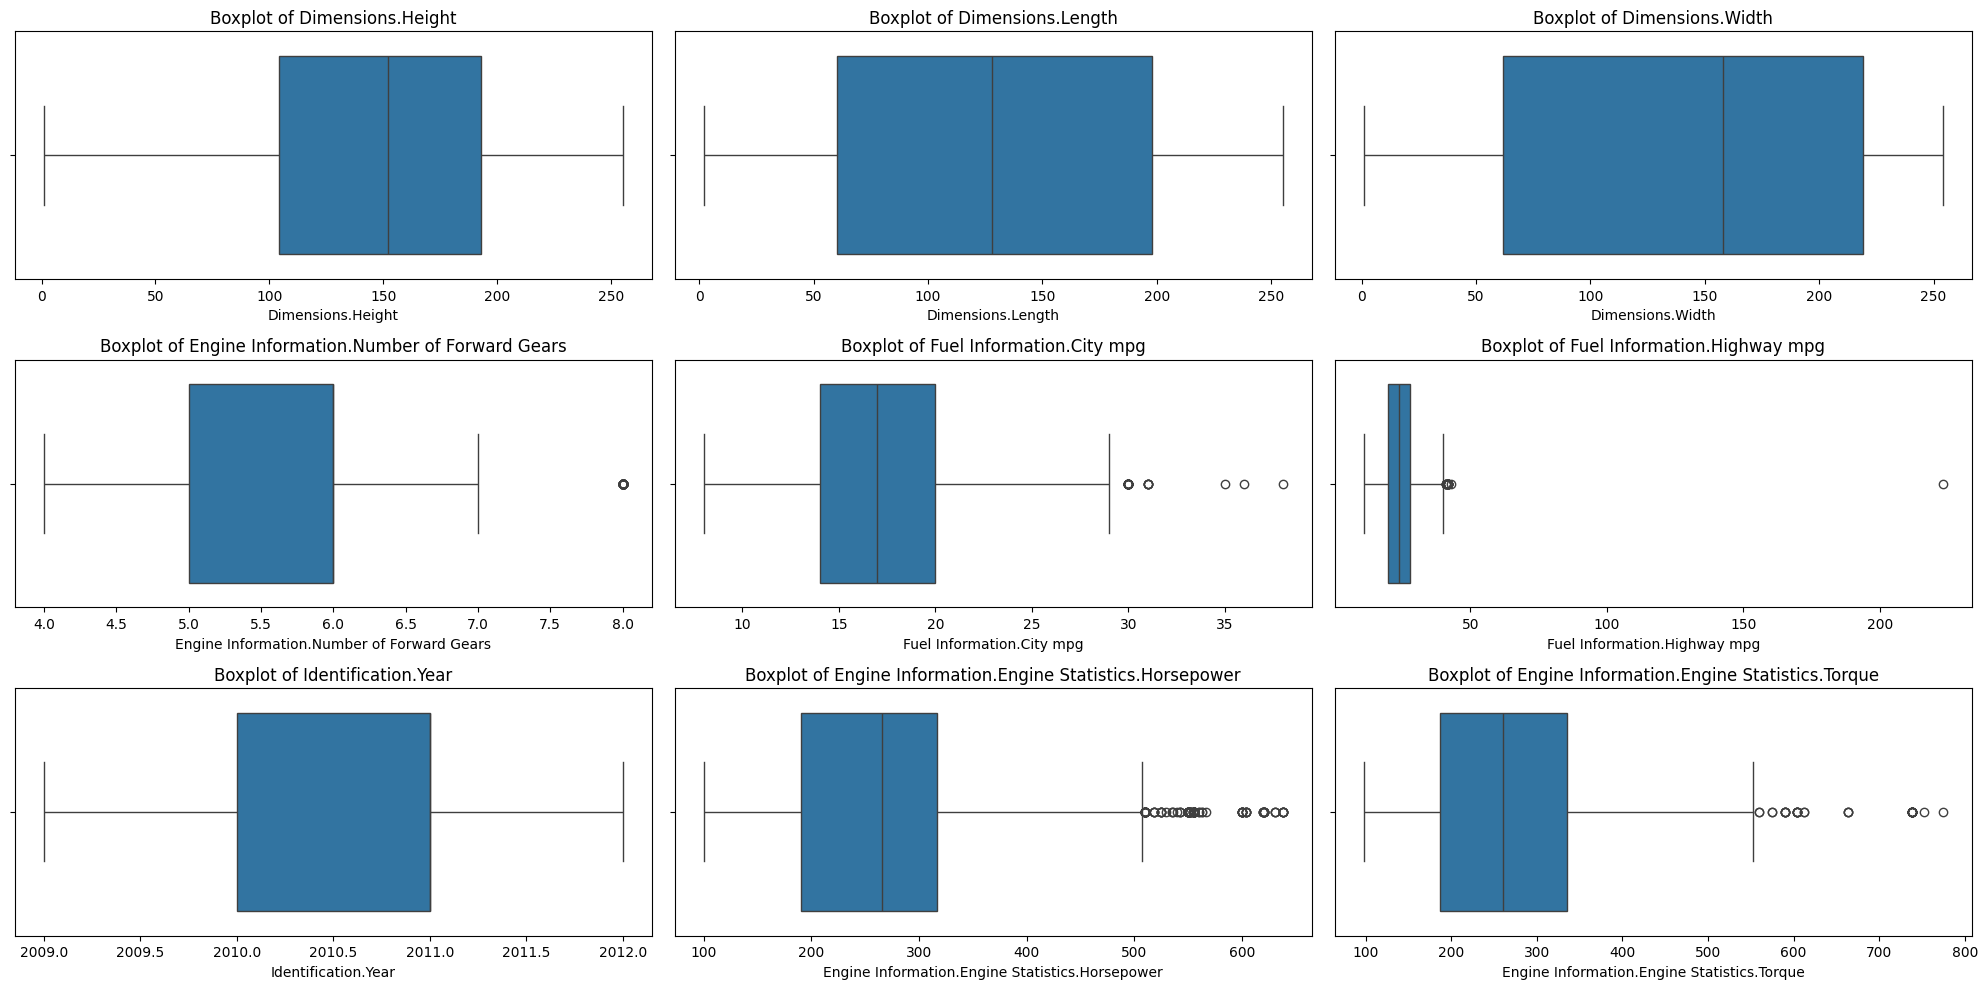

In [160]:
plt.figure(figsize=(20,10))

t=1
for i in numeric_cols:
  plt.subplot(3,3,t)
  sns.boxplot(x=df[i])
  plt.title(f'Boxplot of {i}')
  t+=1
plt.tight_layout()
plt.show()

In [161]:
col_with_outliers = ['Engine Information.Number of Forward Gears','Fuel Information.City mpg','Fuel Information.Highway mpg',
                     'Engine Information.Engine Statistics.Horsepower','Engine Information.Engine Statistics.Torque']

In [162]:
# IQR clipping
for col in col_with_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=lower, upper=upper)

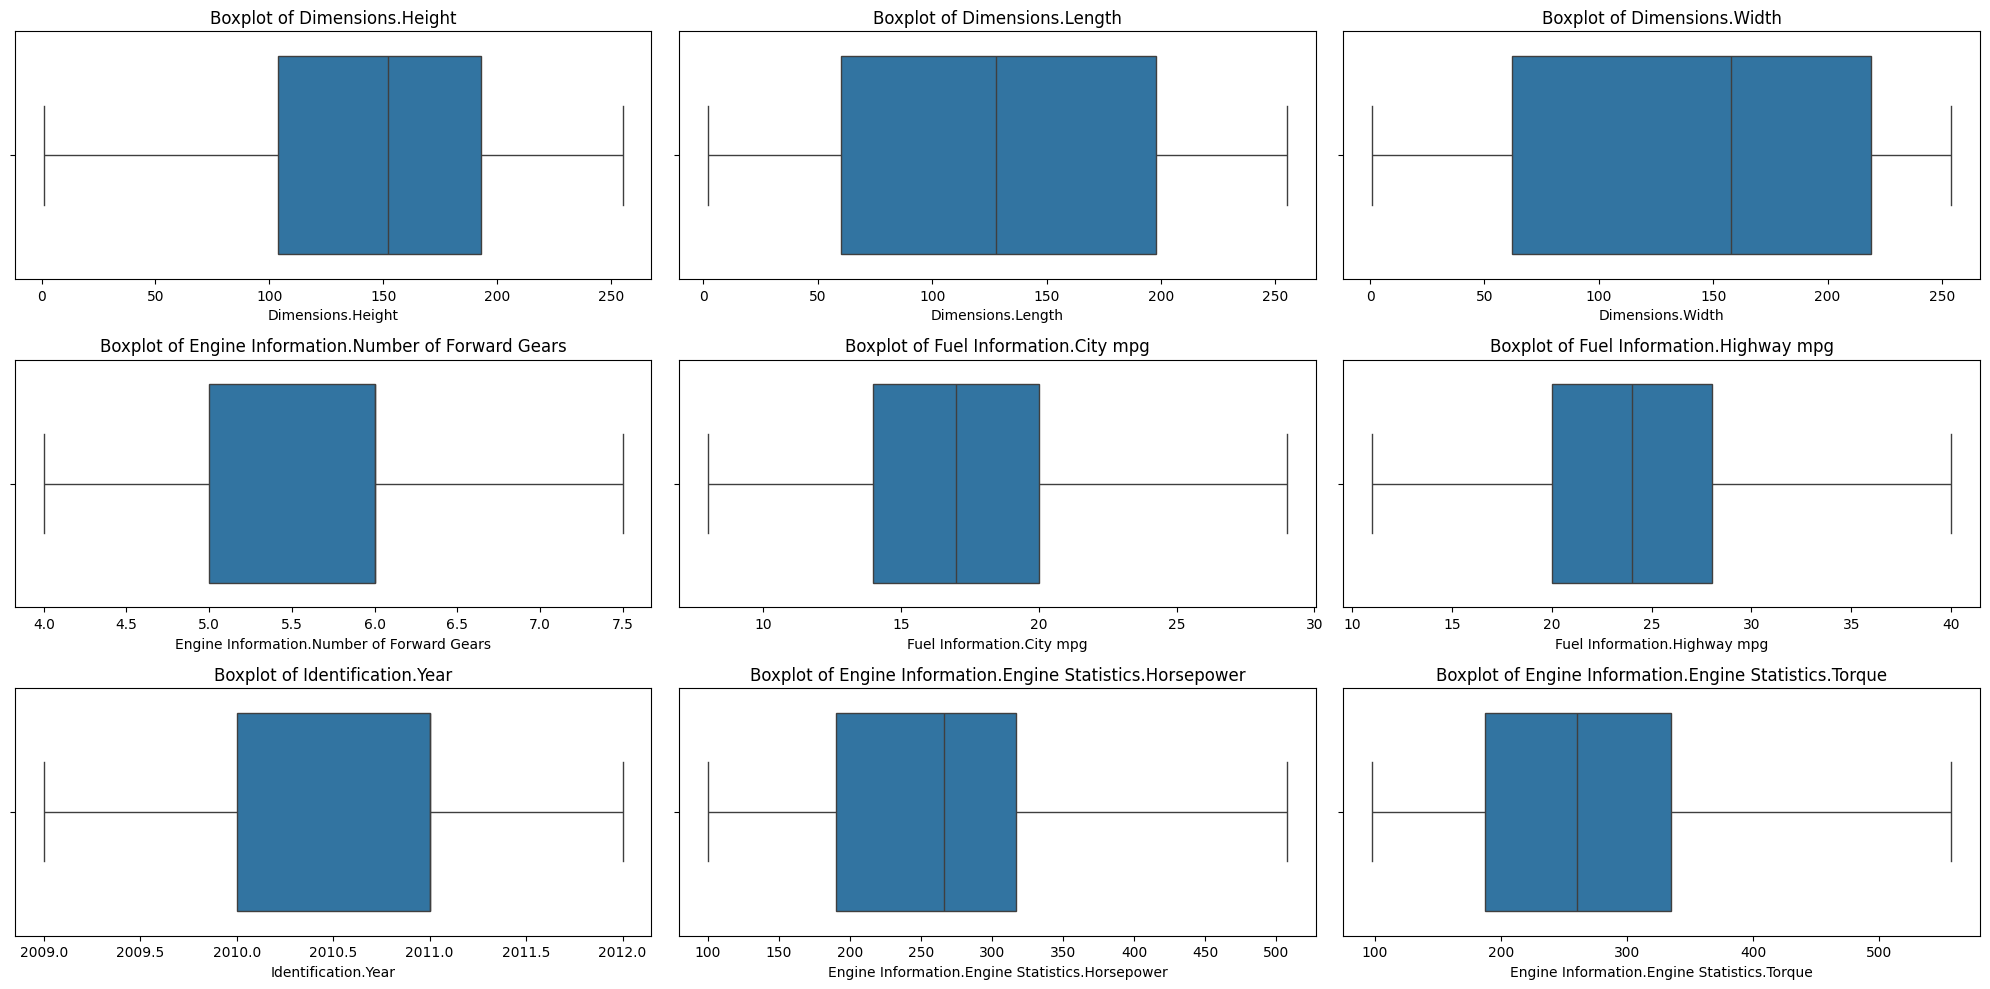

In [163]:
plt.figure(figsize=(20,10))

t=1
for i in numeric_cols:
  plt.subplot(3,3,t)
  sns.boxplot(x=df[i])
  plt.title(f'Boxplot of {i}')
  t+=1
plt.tight_layout()
plt.show()

## Feature Engineering

* New features are created to better represent real-world vehicle behavior and improve predictive performance.


### 1. Vehicle Volume

Vehicle volume is created as a proxy for vehicle mass.


In [164]:
# Vehicle size proxy feature
df['Vehicle_Volume'] = (
    df['Dimensions.Height'] *
    df['Dimensions.Length'] *
    df['Dimensions.Width']
)


In [165]:
df.head(2)

,Dimensions.Height,Dimensions.Length,Dimensions.Width,Engine Information.Driveline,Engine Information.Engine Type,Engine Information.Number of Forward Gears,Engine Information.Transmission,Fuel Information.City mpg,Fuel Information.Fuel Type,Fuel Information.Highway mpg,Identification.Classification,Identification.Make,Identification.Model Year,Identification.Year,Engine Information.Engine Statistics.Horsepower,Engine Information.Engine Statistics.Torque,Vehicle_Volume
0,140,143,202,All-wheel drive,Audi 3.2L 6 cylinder 250hp 236ft-lbs,6.0,6 Speed Automatic Select Shift,18,Gasoline,25,Automatic transmission,Audi,2009 Audi A3,2009,250.0,236,4044040
1,140,143,202,Front-wheel drive,Audi 2.0L 4 cylinder 200 hp 207 ft-lbs Turbo,6.0,6 Speed Automatic Select Shift,22,Gasoline,28,Automatic transmission,Audi,2009 Audi A3,2009,200.0,207,4044040


### 2. Power Index

A power-to-size proxy is created to approximate power-to-weight ratio.


In [166]:
df['Power_Index'] = (
    df['Engine Information.Engine Statistics.Horsepower'] /
    np.log1p(df['Vehicle_Volume'])
)

df['Power_Index'].agg(['min', 'max'])


,Power_Index
min,6.606600
max,52.052287


### 3. Car Age

Car age is derived from model year to capture aging effects.


In [167]:
current_year = 2025
df['Car_Age'] = current_year - df['Identification.Year']

df['Car_Age'].unique()

array([16, 13, 15, 14])

### Target Variable: Average MPG

City and highway mileage are averaged to form a stable target variable.


In [168]:
# Average MPG feature
df['Avg_MPG'] = (
    df['Fuel Information.City mpg'] +
    df['Fuel Information.Highway mpg']
) / 2

df['Avg_MPG'].agg(['min', 'max'])

,Avg_MPG
min,9.5
max,34.5


## Feature Extraction from Engine Description

* The engine description column contains valuable technical information embedded in text.

* Using pattern-based extraction, key engine attributes such as brand, displacement, number of cylinders, horsepower, and torque were derived and converted into structured
numeric features.

* This transformation enables the model to directly leverage engine specifications, improving interpretability and predictive performance.


In [169]:
# Function to extract the brand, displacement, number of cylinders, horsepower, and torque

def extract_features(text):
    if pd.isna(text):
        return pd.Series({
            'brand': np.nan,
            'displacement': np.nan,
            'cylinders': np.nan,
            'hp': np.nan,
            'torque': np.nan
        })

    text = text.lower()

    # Brand (first word only – safe fallback)
    match = re.match(r'^([^\d]+)', text)
    brand = match.group(1).strip().title() if match else text.title()

    # Displacement (e.g. 2.0L)
    disp = re.search(r'(\d+(\.\d+)?)\s*l', text)
    displacement = float(disp.group(1)) if disp else np.nan

    # Cylinders (handles "6 cylinder" and "v6")
    cyl = re.search(r'(\d+)\s*cylinder|v(\d+)', text)
    cylinders = int(cyl.group(1) or cyl.group(2)) if cyl else np.nan

    # Horsepower
    hp_match = re.search(r'(\d+)\s*hp', text)
    hp = int(hp_match.group(1)) if hp_match else np.nan

    # Torque
    torque_match = re.search(r'(\d+)\s*ft[- ]?lbs?', text)
    torque = int(torque_match.group(1)) if torque_match else np.nan

    return pd.Series({
        'brand': brand,
        'displacement': displacement,
        'cylinders': cylinders,
        'hp': hp,
        'torque': torque
    })

In [170]:
df[['brand', 'displacement', 'cylinders', 'hp', 'torque']] = (
    df['Engine Information.Engine Type'].apply(extract_features))

df[['brand', 'displacement', 'cylinders', 'hp', 'torque']].head(3)

,brand,displacement,cylinders,hp,torque
0,Audi,3.2,6.0,250,236.0
1,Audi,2.0,4.0,200,207.0
2,Audi,2.0,4.0,200,207.0


## Null Value Treatment for extracted columns

In [171]:
cols = ['displacement', 'cylinders', 'hp', 'torque']

for i in cols:
  print(i,':',df[i].isnull().sum())
  print()

displacement : 5

cylinders : 19

hp : 0

torque : 25



In [172]:
df[cols] = df[cols].apply(lambda x: x.fillna(x.mean()))

In [173]:
for i in cols:
  print(i,':',df[i].isnull().sum())
  print()

displacement : 0

cylinders : 0

hp : 0

torque : 0



## Brand Anomaly Treatment

* After extracting the `brand` feature from the engine description, minor spelling inconsistencies were identified.

* These anomalies were corrected to ensure category consistency and prevent the creation of redundant or noisy brand values.

* This step improves data quality and ensures reliable downstream analysis.

* Drop the engine info column post extraction

In [174]:
df.drop(columns='Engine Information.Engine Type',inplace=True)

# Sample correction mapping
corrections = {
    'Bmw': 'BMW',
    'Gmc': 'GMC',
    'Mini': 'MINI',
    'Mercedes-Amg': 'Mercedes-Benz',
    'Maybach': 'Mercedes-Benz'
}

# Apply corrections to the 'brand' column
df['brand'] = df['brand'].apply(lambda x: corrections.get(x, x))

# Optional: remove duplicates if you later want a list of unique brands
unique_brands = df['brand'].drop_duplicates().tolist()

print("Unique brands after cleaning:", unique_brands)
print()
df['brand'].unique()

Unique brands after cleaning: ['Audi', 'Acura', 'BMW', 'Chevrolet', 'Nissan', 'Volvo', 'Bentley', 'Toyota', 'Honda', 'Ford', 'Rolls-Royce', 'Volkswagen', 'Mercedes-Benz', 'Lamborghini', 'Lexus', 'Hyundai', 'Kia', 'Mazda', 'Cadillac', 'Mitsubishi', 'Infiniti', 'Dodge', 'Lincoln', 'GMC', 'Porsche', 'Jeep', 'Subaru', 'Buick', 'Suzuki', 'Saab', 'Aston Martin', 'Land Rover', 'Chrysler', 'Ferrari', 'Scion', 'MINI', 'Jaguar', 'Lotus', 'Maserati', 'Mercury']



array(['Audi', 'Acura', 'BMW', 'Chevrolet', 'Nissan', 'Volvo', 'Bentley',
       'Toyota', 'Honda', 'Ford', 'Rolls-Royce', 'Volkswagen',
       'Mercedes-Benz', 'Lamborghini', 'Lexus', 'Hyundai', 'Kia', 'Mazda',
       'Cadillac', 'Mitsubishi', 'Infiniti', 'Dodge', 'Lincoln', 'GMC',
       'Porsche', 'Jeep', 'Subaru', 'Buick', 'Suzuki', 'Saab',
       'Aston Martin', 'Land Rover', 'Chrysler', 'Ferrari', 'Scion',
       'MINI', 'Jaguar', 'Lotus', 'Maserati', 'Mercury'], dtype=object)

In [175]:
luxury_brands = {
    'Audi','Acura','BMW','Volvo','Bentley','Rolls-Royce',
    'Lamborghini','Lexus','Mercedes-Benz','Cadillac','Infiniti','Lincoln','Porsche','Jaguar',
    'Aston Martin','Land Rover','Ferrari','Lotus','Maserati','Saab'
}

df['market_segment'] = df['brand'].apply(
    lambda x: 'Luxury' if x in luxury_brands else 'Economy'
)


In [176]:
print(df['market_segment'].value_counts())
df.head()

market_segment
Economy    3874
Luxury     1184
Name: count, dtype: int64


,Dimensions.Height,Dimensions.Length,Dimensions.Width,Engine Information.Driveline,Engine Information.Number of Forward Gears,Engine Information.Transmission,Fuel Information.City mpg,Fuel Information.Fuel Type,Fuel Information.Highway mpg,Identification.Classification,Identification.Make,Identification.Model Year,Identification.Year,Engine Information.Engine Statistics.Horsepower,Engine Information.Engine Statistics.Torque,Vehicle_Volume,Power_Index,Car_Age,Avg_MPG,brand,displacement,cylinders,hp,torque,market_segment
0,140,143,202,All-wheel drive,6.0,6 Speed Automatic Select Shift,18,Gasoline,25,Automatic transmission,Audi,2009 Audi A3,2009,250.0,236,4044040,16.433578,16,21.5,Audi,3.2,6.0,250,236.0,Luxury
1,140,143,202,Front-wheel drive,6.0,6 Speed Automatic Select Shift,22,Gasoline,28,Automatic transmission,Audi,2009 Audi A3,2009,200.0,207,4044040,13.146863,16,25.0,Audi,2.0,4.0,200,207.0,Luxury
2,140,143,202,Front-wheel drive,6.0,6 Speed Manual,21,Gasoline,30,Manual transmission,Audi,2009 Audi A3,2009,200.0,207,4044040,13.146863,16,25.5,Audi,2.0,4.0,200,207.0,Luxury
3,140,143,202,All-wheel drive,6.0,6 Speed Automatic Select Shift,21,Gasoline,28,Automatic transmission,Audi,2009 Audi A3,2009,200.0,207,4044040,13.146863,16,24.5,Audi,2.0,4.0,200,207.0,Luxury
5,91,17,62,All-wheel drive,6.0,6 Speed Manual,16,Gasoline,27,Manual transmission,Audi,2009 Audi A5,2009,265.0,243,95914,23.101296,16,21.5,Audi,3.2,6.0,265,243.0,Luxury


In [177]:
df.drop(columns='brand',inplace=True)


## Transmission Feature Simplification

* The transmission description column contains both transmission type and gear count.

* Since the number of gears is already available as a separate feature, the gear-related information was removed from this column to avoid redundancy.

* Only the transmission type is retained, ensuring a cleaner and non-duplicated feature set.


In [178]:
df['Engine Information.Transmission'].unique()

array(['6 Speed Automatic Select Shift', '6 Speed Manual',
       '5 Speed Manual', '4 Speed Automatic', '6 Speed Automatic',
       '5 Speed Automatic', '5 Speed Automatic Select Shift',
       '7 Speed Automatic Select Shift', '8 Speed Automatic Select Shift',
       '7 Speed Automatic', '4 Speed Automatic Select Shift'],
      dtype=object)

In [179]:
# Remove the number of gears (e.g., '6 Speed', '4 Speed') from the 'Engine Information.Transmission' column

df['Engine Information.Transmission'] = df['Engine Information.Transmission'].str.replace(r'^\d+\sSpeed\s', '', regex=True)

df['Engine Information.Transmission'].unique()

array(['Automatic Select Shift', 'Manual', 'Automatic'], dtype=object)

In [180]:
df['Identification.Classification'].unique()

array(['Automatic transmission', 'Manual transmission'], dtype=object)

#### We can infer almost similar information from both Transimission & Classification columns so dropping Classification column to avoid redundancy

In [181]:
df.drop(columns='Identification.Classification',inplace=True)


In [182]:
df['Identification.Make'].unique()

array(['Audi', 'Acura', 'BMW', 'Chevrolet', 'Nissan', 'Volvo', 'Bentley',
       'Toyota', 'Honda', 'Ford', 'Rolls-Royce', 'Volkswagen', 'Maybach',
       'Lamborghini', 'Lexus', 'Hyundai', 'Mercedes', 'BMW Motorrad',
       'Kia', 'AMG', 'Mazda', 'Mercedes-Benz', 'Mercedes-AMG',
       'Mitsubishi', 'Cadillac', 'Infiniti', 'Dodge', 'Lincoln', 'GMC',
       'Porsche', 'Jeep', 'Subaru', 'Buick', 'Suzuki', 'Saab',
       'Aston Martin', 'Grand Cherokee', 'Land Rover', 'Chrysler',
       'Ferrari', 'Scion', 'MINI', 'Jaguar', 'Chrysler Group LLC',
       'Lotus', 'Maserati', 'Mercury'], dtype=object)

#### * Since we already have brand column it explain more than Id.make column so Make column is being dropped.

#### * Also Make column has some mis-classified words so dropping it.

In [183]:
df.drop(columns='Identification.Make',inplace=True)

In [184]:
df['Identification.Model Year'].unique()

array(['2009 Audi A3', '2009 Audi A5', '2009 Audi Q7',
       '2009 Audi A4 Sedan', '2012 Acura TL', '2010 BMW X5',
       '2011 BMW X5', '2010 BMW X6', '2011 BMW X6',
       '2012 Chevrolet Colorado', '2011 Chevrolet Colorado',
       '2010 Chevrolet Colorado', '2012 Chevrolet Express',
       '2011 Chevrolet Express', '2010 Chevrolet Express',
       '2011 Chevrolet Silverado 1500', '2010 Chevrolet Silverado 1500',
       '2011 Nissan 370Z Coupe', '2010 Nissan 370Z Coupe',
       '2009 Nissan 370Z Coupe', '2011 Volvo C30', '2010 Volvo C30',
       '2010 Bentley Brooklands',
       '2012 Bentley Continental Supersports Convertible',
       '2012 Bentley Continental Supersports Coupe',
       '2011 Bentley Continental Supersports Convertible',
       '2010 Bentley Continental Supersports',
       '2012 Bentley Continental Flying Spur',
       '2011 Bentley Continental Flying Spur',
       '2010 Bentley Continental Flying Spur', '2011 Volvo C70',
       '2010 Volvo C70', '2010 Volvo S40

## Model Name Cleaning

* The `model` column contains both the vehicle year and model name.

* Since the year information is already available as a separate feature, the year component is removed to avoid redundancy.

* Only the cleaned model name is retained for consistency and clarity.


In [185]:
df['Identification.Model Year'] = df['Identification.Model Year'].str.replace(r'^\d{4}\s+', '', regex=True)

df['Identification.Model Year'].value_counts()

,count
Identification.Model Year,
Ford F-150,179
GMC Sierra 1500,124
Chevrolet Silverado 1500,116
Chevrolet Colorado,114
Dodge Ram 1500,109
GMC Canyon,77
Nissan Titan,70
Toyota Tundra,64
Nissan Frontier,55


In [186]:
def classify_vehicle(name):
    if pd.isna(name):
        return 'Others'

    name = name.lower()

    pickup_keywords = [
        'pickup','silverado','sierra','f-150','f-250','f-350', 'tacoma','tundra','ranger','colorado','frontier','titan','ram',
        "GMC Canyon", "Dodge Dakota", "Chevrolet Avalanche", "Honda Ridgeline", "Suzuki Equator"
    ]

    suv_keywords = [
        'suv','crossover','x3','x5','x6','x7', 'q3','q5','q7', 'xc','cr-v','rav4','highlander','4runner',
        'escape','explorer','edge','flex','cx-','tiguan','touareg', 'grand cherokee','wrangler','compass','patriot',
        'range rover','land cruiser','sequoia','equinox','traverse','acadia','terrain',
        'sorento','sportage','santa fe','tucson','pilot','pathfinder','armada','xterra',
        'outlander','forester','outback',"Yukon", "Escalade", "Tahoe", "Suburban", "Expedition",
        "Cayenne", "Enclave", "Veracruz", "Venza","Navigator", "Liberty", "Commander", "Durango",
        "Journey", "Avalanche", "LR2", "LR4", "M-Class", "GL-Class", "GLK-Class", "G-Class", "FX", "EX",
        "RX", "LX", "MDX", "RDX", "ZDX", "SRX", "Toyota Sienna", "GMC Yukon XL", "Jeep Liberty", "Dodge Durango",
        "Buick Enclave", "Dodge Journey", "Mazda Tribute", "Dodge Nitro","Infiniti EX", "GMC Yukon", "Cadillac SRX", "Mercury Mariner",
        "Chevrolet Tahoe", "Porsche Cayenne", "Honda Element","Volkswagen Routan", "GMC Yukon Hybrid", "Infiniti FX",
        "Lincoln MKT", "Toyota Venza", "Land Rover LR4", "Kia Sedona", "Chevrolet Suburban Half-Ton", "Jeep Commander",
        "Lincoln MKX", "Volvo C70", "Land Rover LR2", "Chevrolet Suburban Three-Quarter-Ton", "Acura RDX",
        "Acura MDX", "Acura ZDX", "Lexus RX", "Lexus LX", "Chevrolet Suburban", "Chevrolet Tahoe Hybrid",
        "Porsche Cayenne S Hybrid"

    ]

    hatch_keywords = [
        'hatch','hatchback','gti','golf','5-door','yaris','fit', 'fiesta hatch','mazda3 5','accent hatch','cooper hardtop','veloster',
        "Volkswagen Jetta SportWagen", "Chevrolet HHR Wagon", "Toyota Matrix", "Kia Soul", "MINI Clubman", "MINI Countryman",
        "Scion xB", "Scion tC", "Chevrolet Aveo5", "Scion xD", "Mazda Mazda2", "Mazda Mazda5", "Suzuki SX4 Sportback",
        "Mazda Mazdaspeed3", "Volkswagen Beetle", "Acura TSX Sport Wagon", "Volvo V50", "Volvo V70"
    ]

    sedan_keywords = [
        "Volkswagen Jetta", "Buick Lacrosse", "Subaru Legacy", "Kia Optima", "Infiniti M", "Hyundai Veracruz", "Buick Regal", "Buick Lucerne",
        "Chrysler 300", "Dodge Charger", "Volkswagen CC", "Mercury Milan", "Lincoln MKS", "Acura TL", "Kia Rio", "Suzuki Kizashi",
        "Audi A3", "Volkswagen Passat", "Chevrolet Aveo", "Buick Verano", "Acura RL", "Lincoln MKZ", "Ford Crown Victoria",
        "Infiniti M Hybrid" 'sedan', 'a4','a6','a8','3 series','5 series','7 series',
        'c-class','e-class','s-class',"sedan", "4-door", "four door", "saloon", "camry", "corolla", "avalon",
        "accord", "civic", "sonata", "elantra", "azera","fusion", "taurus", "impala", "malibu",
        "sentra", "versa", "altima", "a4", "a6", "a8", "s4", "s6", "a7", "3 series", "5 series", "7 series",
        "c-class", "e-class", "cls-class","is", "es", "gs", "ls","cts", "sts", "dts",
        "xf", "xj", "s40", "s60", "s80", "quattroporte", "equus","phantom", "ghost"
        'camry','corolla','accord','civic','altima','sentra','sonata','elantra','es','is','ls',
    ]

    if any(k in name for k in pickup_keywords):
        return 'Pickup Truck'
    elif any(k in name for k in suv_keywords):
        return 'SUV / Crossover'
    elif any(k in name for k in hatch_keywords):
        return 'Hatchback'
    elif any(k in name for k in sedan_keywords):
        return 'Sedan'
    else:
        return 'Others'


df['car_body_type'] = df['Identification.Model Year'].apply(classify_vehicle)

In [187]:
print(df['car_body_type'].value_counts())
# print()
# df.head()

car_body_type
Others             1829
Sedan              1211
SUV / Crossover     925
Pickup Truck        925
Hatchback           168
Name: count, dtype: int64


In [188]:
df.drop(columns='Identification.Model Year',inplace=True)

## Redundant Feature Removal

* Horsepower and torque were present in both original numeric columns and extracted features.

* To avoid duplication and multicollinearity, the redundant original columns were removed.

* Similarly, individual vehicle dimensions (height, length, width) were dropped after creating the consolidated `car_volume` feature.

* The `make_year` column was also removed since car age is already captured through the derived `Car_Age` feature.

* This ensures a compact, non-redundant, and interpretable feature set.


In [189]:
df.columns

Index(['Dimensions.Height', 'Dimensions.Length', 'Dimensions.Width',
       'Engine Information.Driveline',
       'Engine Information.Number of Forward Gears',
       'Engine Information.Transmission', 'Fuel Information.City mpg',
       'Fuel Information.Fuel Type', 'Fuel Information.Highway mpg',
       'Identification.Year',
       'Engine Information.Engine Statistics.Horsepower',
       'Engine Information.Engine Statistics.Torque', 'Vehicle_Volume',
       'Power_Index', 'Car_Age', 'Avg_MPG', 'displacement', 'cylinders', 'hp',
       'torque', 'market_segment', 'car_body_type'],
      dtype='object')

In [190]:
df.drop(columns=['Engine Information.Engine Statistics.Horsepower','Engine Information.Engine Statistics.Torque',
                 'Dimensions.Height', 'Dimensions.Length', 'Dimensions.Width','Identification.Year'], inplace=True)

## Renaming the columns

In [191]:
df.rename(columns={
    'Engine Information.Driveline': 'driveline_style',
    'Engine Information.Number of Forward Gears': 'no_of_gears',
    'Engine Information.Transmission': 'transmission_type',
    'Fuel Information.City mpg': 'city_mpg',
    'Fuel Information.Fuel Type': 'fuel_type',
    'Fuel Information.Highway mpg': 'highway_mpg',
    'Identification.Model Year': 'model',
    'Vehicle_Volume': 'car_volume'}, inplace=True)

In [192]:
df.columns

Index(['driveline_style', 'no_of_gears', 'transmission_type', 'city_mpg',
       'fuel_type', 'highway_mpg', 'car_volume', 'Power_Index', 'Car_Age',
       'Avg_MPG', 'displacement', 'cylinders', 'hp', 'torque',
       'market_segment', 'car_body_type'],
      dtype='object')

In [193]:
df.head()

,driveline_style,no_of_gears,transmission_type,city_mpg,fuel_type,highway_mpg,car_volume,Power_Index,Car_Age,Avg_MPG,displacement,cylinders,hp,torque,market_segment,car_body_type
0,All-wheel drive,6.0,Automatic Select Shift,18,Gasoline,25,4044040,16.433578,16,21.5,3.2,6.0,250,236.0,Luxury,Others
1,Front-wheel drive,6.0,Automatic Select Shift,22,Gasoline,28,4044040,13.146863,16,25.0,2.0,4.0,200,207.0,Luxury,Others
2,Front-wheel drive,6.0,Manual,21,Gasoline,30,4044040,13.146863,16,25.5,2.0,4.0,200,207.0,Luxury,Others
3,All-wheel drive,6.0,Automatic Select Shift,21,Gasoline,28,4044040,13.146863,16,24.5,2.0,4.0,200,207.0,Luxury,Others
5,All-wheel drive,6.0,Manual,16,Gasoline,27,95914,23.101296,16,21.5,3.2,6.0,265,243.0,Luxury,Others


In [194]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", num_cols)
print()
print("Categorical columns:", cat_cols)

Numeric columns: ['no_of_gears', 'city_mpg', 'highway_mpg', 'car_volume', 'Power_Index', 'Car_Age', 'Avg_MPG', 'displacement', 'cylinders', 'hp', 'torque']

Categorical columns: ['driveline_style', 'transmission_type', 'fuel_type', 'market_segment', 'car_body_type']


## Outlier Detection & Treatment

- Extreme values can distort regression models.

- IQR-based clipping is used to cap outliers without removing data.


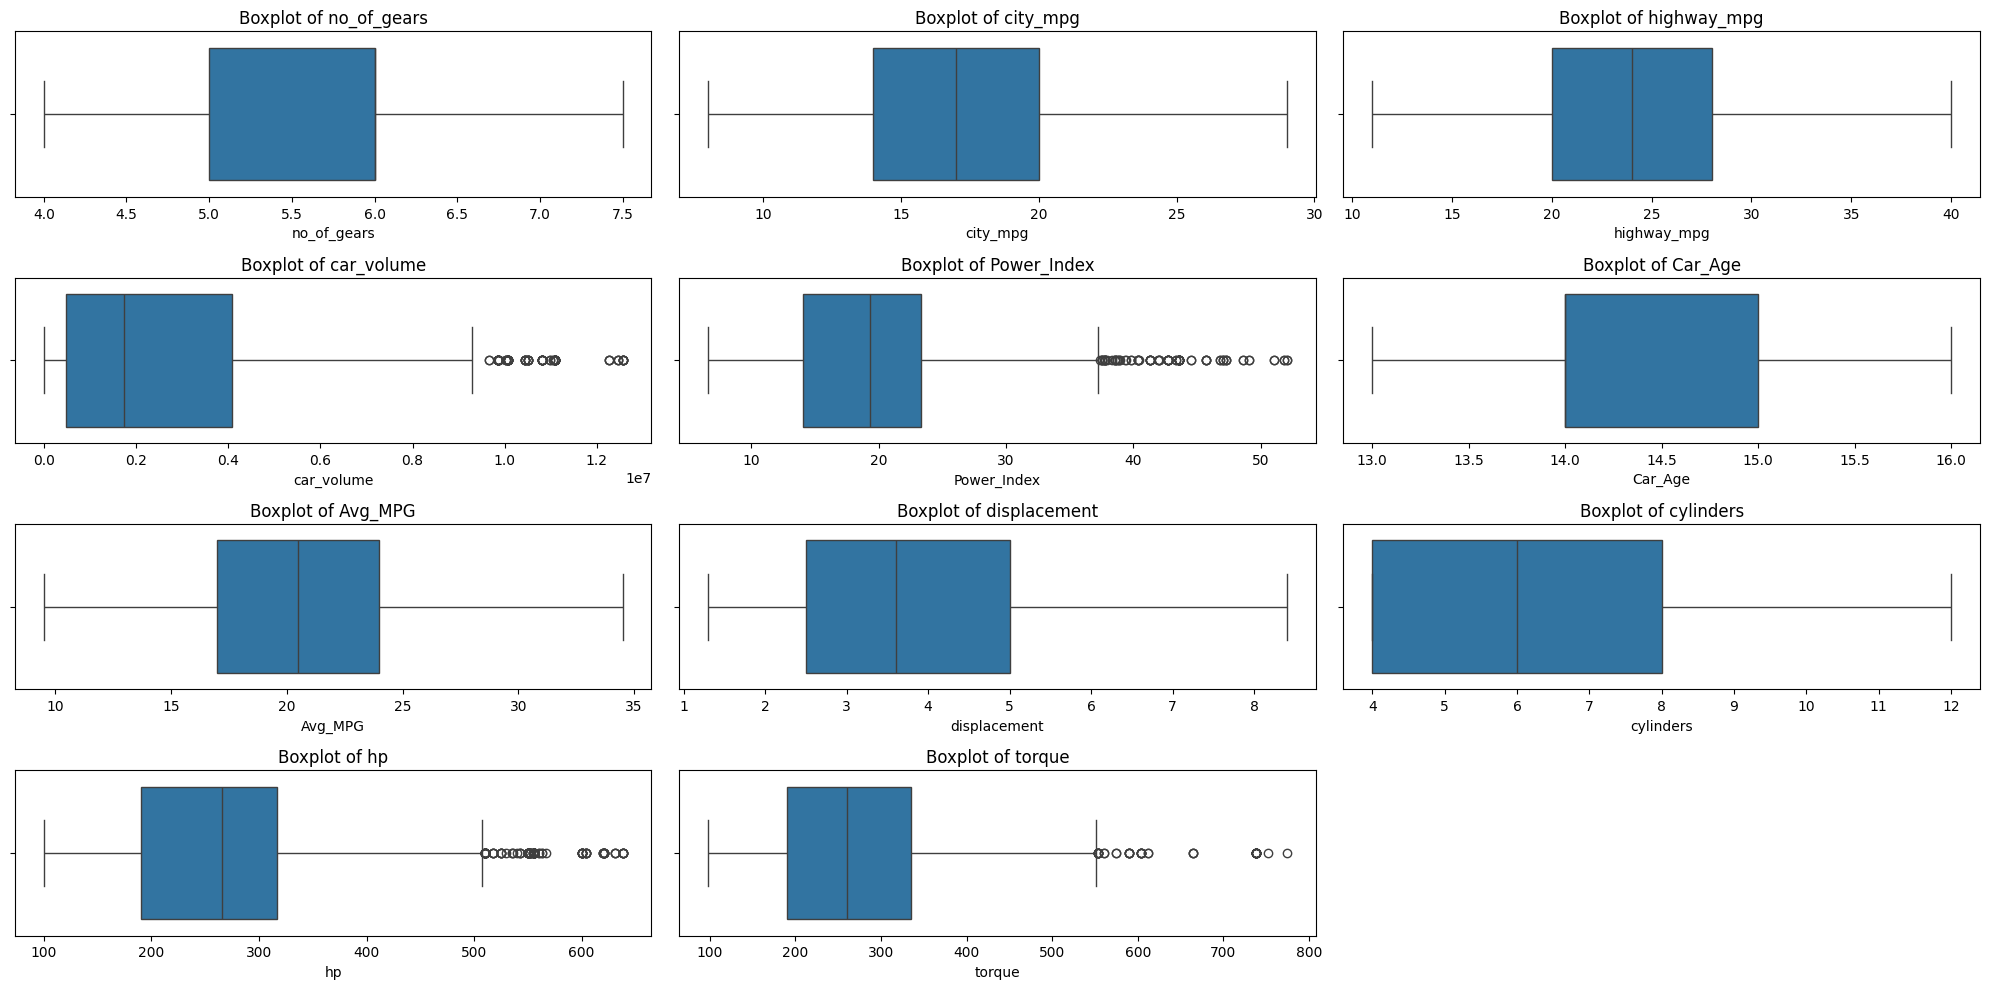

In [195]:
plt.figure(figsize=(20,10))

t=1
for i in num_cols:
  plt.subplot(4,3,t)
  sns.boxplot(x=df[i])
  plt.title(f'Boxplot of {i}')
  t+=1
plt.tight_layout()
plt.show()

In [196]:
# IQR clipping
for col in ['car_volume','Power_Index','hp','torque']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=lower, upper=upper)

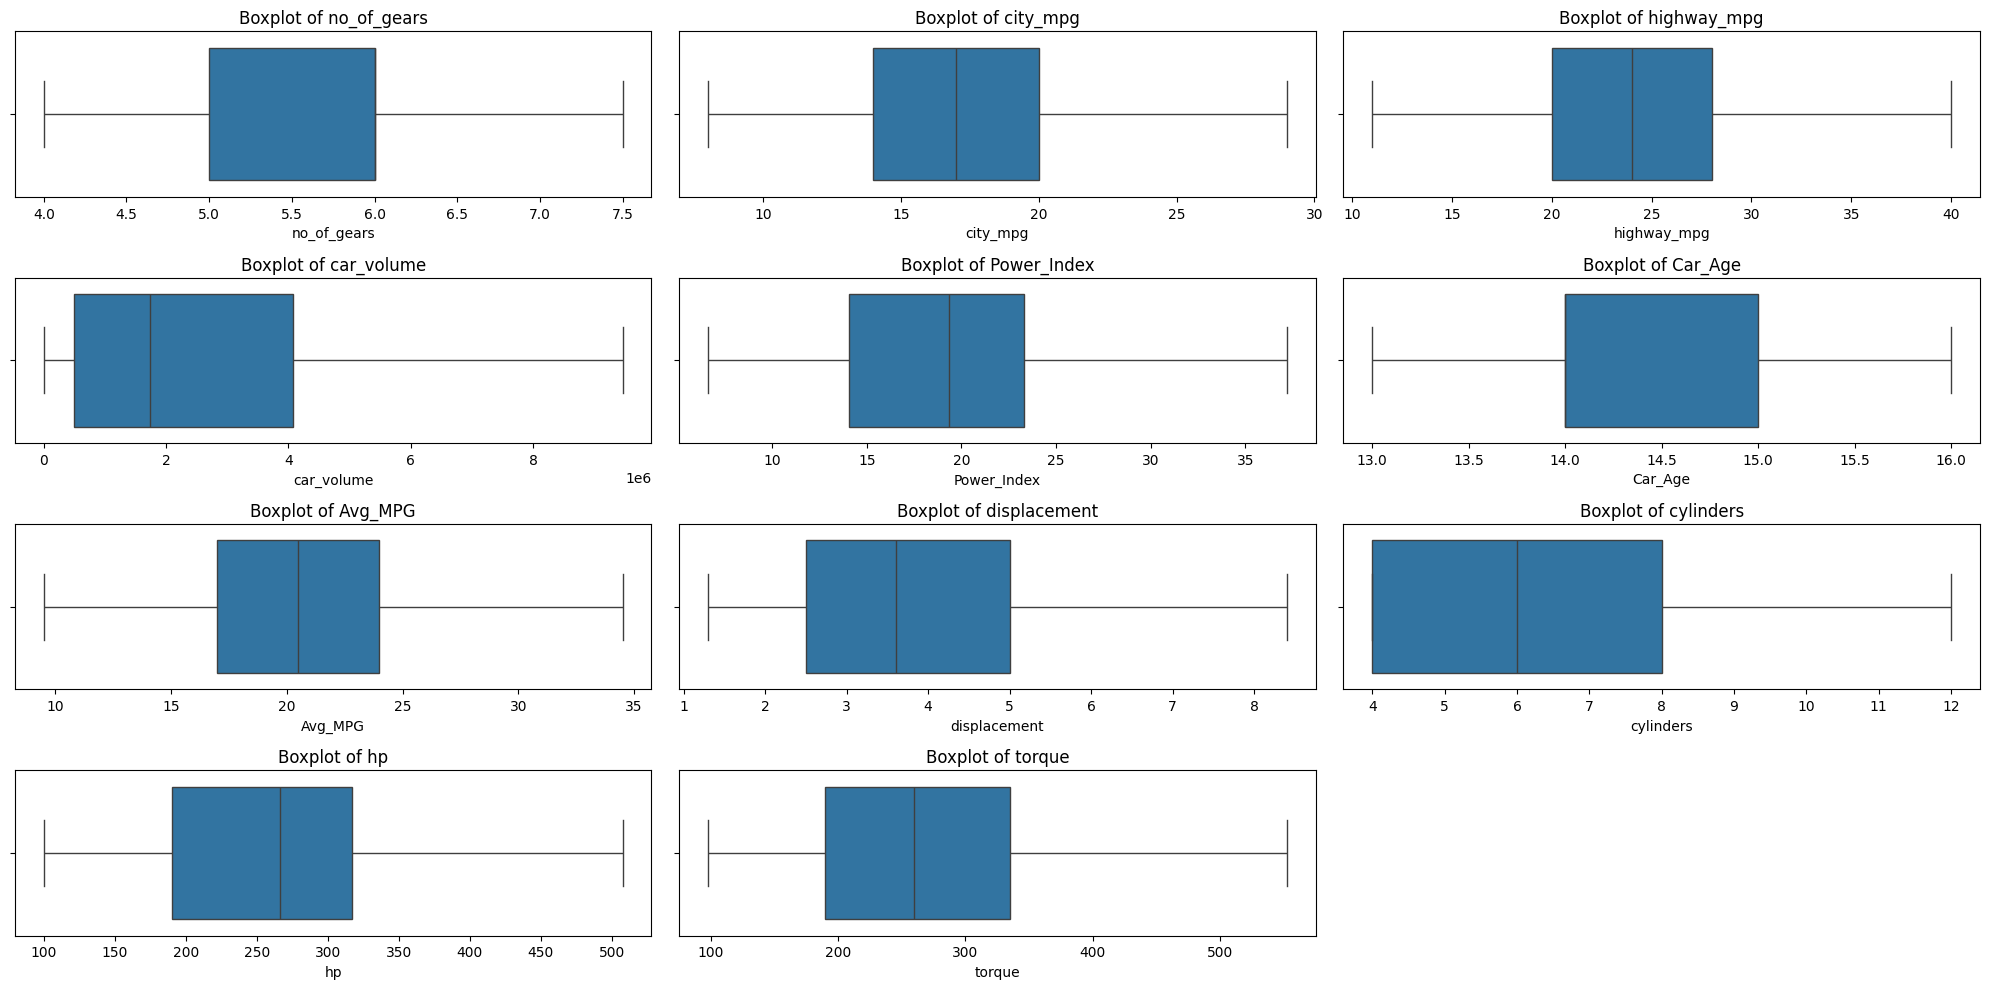

In [197]:
plt.figure(figsize=(20,10))

t=1
for i in num_cols:
  plt.subplot(4,3,t)
  sns.boxplot(x=df[i])
  plt.title(f'Boxplot of {i}')
  t+=1
plt.tight_layout()
plt.show()

In [198]:
df[num_cols].head()

,no_of_gears,city_mpg,highway_mpg,car_volume,Power_Index,Car_Age,Avg_MPG,displacement,cylinders,hp,torque
0,6.0,18,25,4044040,16.433578,16,21.5,3.2,6.0,250.0,236.0
1,6.0,22,28,4044040,13.146863,16,25.0,2.0,4.0,200.0,207.0
2,6.0,21,30,4044040,13.146863,16,25.5,2.0,4.0,200.0,207.0
3,6.0,21,28,4044040,13.146863,16,24.5,2.0,4.0,200.0,207.0
5,6.0,16,27,95914,23.101296,16,21.5,3.2,6.0,265.0,243.0


In [199]:
for i in cat_cols:
  print(f'{i} : {df[i].dtype} : Tot unique values - {len(df[i].unique())}')
  print()
  print(df[i].unique())
  print()
  print('*'*20)

driveline_style : object : Tot unique values - 4

['All-wheel drive' 'Front-wheel drive' 'Rear-wheel drive'
 'Four-wheel drive']

********************
transmission_type : object : Tot unique values - 3

['Automatic Select Shift' 'Manual' 'Automatic']

********************
fuel_type : object : Tot unique values - 4

['Gasoline' 'E85' 'Diesel fuel' 'Compressed natural gas']

********************
market_segment : object : Tot unique values - 2

['Luxury' 'Economy']

********************
car_body_type : object : Tot unique values - 5

['Others' 'SUV / Crossover' 'Sedan' 'Pickup Truck' 'Hatchback']

********************


## Categorical Feature Encoding

* Categorical variables were transformed using one-hot encoding, frequency encoding and stored in a separate DataFrame for modeling purposes.

* This allows the model to capture category-specific effects while preserving the original cleaned dataset in a human-readable format for analysis and reuse.

* This encoded dataset is used exclusively for machine learning and deployment.

In [200]:
# # Frequency encoding for model
# model_freq = df['model'].value_counts(normalize=True) * 100
# df['model_freq'] = df['model'].map(model_freq)

# # Drop original model column
# df.drop(columns=['model'], inplace=True)


# One Hot Encoding for remaining categoric columns

cat_encoded_cols = ['car_body_type', 'driveline_style', 'transmission_type', 'fuel_type', 'market_segment']

# Create a new dataframe for modeling
df_cat_encoded_cols = pd.get_dummies(df[cat_encoded_cols], columns=cat_encoded_cols, drop_first=True)

In [201]:
df_cat_encoded_cols.head()

,car_body_type_Others,car_body_type_Pickup Truck,car_body_type_SUV / Crossover,car_body_type_Sedan,driveline_style_Four-wheel drive,driveline_style_Front-wheel drive,driveline_style_Rear-wheel drive,transmission_type_Automatic Select Shift,transmission_type_Manual,fuel_type_Diesel fuel,fuel_type_E85,fuel_type_Gasoline,market_segment_Luxury
0,True,False,False,False,False,False,False,True,False,False,False,True,True
1,True,False,False,False,False,True,False,True,False,False,False,True,True
2,True,False,False,False,False,True,False,False,True,False,False,True,True
3,True,False,False,False,False,False,False,True,False,False,False,True,True
5,True,False,False,False,False,False,False,False,True,False,False,True,True


In [202]:
df.head()

,driveline_style,no_of_gears,transmission_type,city_mpg,fuel_type,highway_mpg,car_volume,Power_Index,Car_Age,Avg_MPG,displacement,cylinders,hp,torque,market_segment,car_body_type
0,All-wheel drive,6.0,Automatic Select Shift,18,Gasoline,25,4044040,16.433578,16,21.5,3.2,6.0,250.0,236.0,Luxury,Others
1,Front-wheel drive,6.0,Automatic Select Shift,22,Gasoline,28,4044040,13.146863,16,25.0,2.0,4.0,200.0,207.0,Luxury,Others
2,Front-wheel drive,6.0,Manual,21,Gasoline,30,4044040,13.146863,16,25.5,2.0,4.0,200.0,207.0,Luxury,Others
3,All-wheel drive,6.0,Automatic Select Shift,21,Gasoline,28,4044040,13.146863,16,24.5,2.0,4.0,200.0,207.0,Luxury,Others
5,All-wheel drive,6.0,Manual,16,Gasoline,27,95914,23.101296,16,21.5,3.2,6.0,265.0,243.0,Luxury,Others


## Saving Cleaned Dataset

* After completing data cleaning and feature engineering, the processed dataset is saved as a separate file.

* This ensures the raw data remains unchanged while allowing the
cleaned version to be reused for modeling, deployment, and future experiments.


In [203]:
# Define path to save cleaned data
cleaned_data_path = '/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/data/copy_cleaned_cars.csv'

# Save cleaned DataFrame
df.to_csv(cleaned_data_path, index=False)

print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.


In [204]:
# Define path to save cleaned data
cleaned_data_path = '/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/data/copy_cleaned_num_data_cars.csv'

# Save cleaned DataFrame
df[num_cols].to_csv(cleaned_data_path, index=False)

print("Cleaned dataset saved successfully.")


Cleaned dataset saved successfully.


In [205]:
# Define path to save cleaned data
cleaned_data_path = '/content/drive/MyDrive/Gen AI GL/Regression Project/Car_Meilage_Prediction/data/copy_cleaned_cat_endoded_data_cars.csv'

# Save cleaned DataFrame
df_cat_encoded_cols.to_csv(cleaned_data_path, index=False)

print("Cleaned dataset saved successfully.")


Cleaned dataset saved successfully.
